<a href="https://colab.research.google.com/github/morwald/ada_project/blob/master/gender_topics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of gender distribution in UK's leading newspapers
# Gender representation

## Content
1. [Setup](#setup)   
    1.1 [Global](#global_setup)  
    1.2 [Local](#local_setup)

## 1. Setup
<a id="setup"></a>

### 1.1 Global
<a id="global_setup"></a>

In [1]:
# Change to true if you want to use google colab
use_colab = True

# Import with EPFL google drive!
if use_colab:
    from google.colab import drive
    drive._mount('/content/drive', force_remount=True)
    %cd /content/drive/Shareddrives/ADA-project
    #!pip install pandas==1.0.5 # downgrade pandas for chunk processing support

Mounted at /content/drive
/content/drive/Shareddrives/ADA-project


In [2]:
# Defined paths for the data
from scripts.path_defs import *

# Defined newspapers and urls
from scripts.newspapers import *

# Globally used functions
from scripts.utility_functions import load_mini_version_of_data
from scripts.utility_functions import convert_to_1Dseries
from scripts.utility_functions import process_data_in_chunks

# Counter to merge dictionaries
from collections import Counter

### 1.2 Local 
<a id="local_setup"></a>

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import bz2

In [4]:
! pip install empath

In [5]:
from empath import Empath
lexicon = Empath()

In [6]:
quotes_df = pd.read_json(MERGED_QUOTES_2020_PATH, lines=True, compression='bz2')
doc_complete = quotes_df.quotation.tolist()

In [ ]:
doc_complete[1]

"And for the record, Eamonn Holmes made me laugh, he lightened a very emotional moment and I'm very happy that he did."

In [16]:
lexicon.create_category("metoo",["metoo","#metoo","consent", "harassment", "sexual assault", "sexual misconduct"], model='nytimes')

["harassment", "consent", "coercion", "notification", "legal_rights", "due_process", "criminal_prosecution", "constitutional_rights", "such_conduct", "abuse", "unlawful", "court_orders", "confidentiality", "sexual_harassment", "illegal_activity", "criminal_proceedings", "misconduct", "violation", "sexual_activity", "sexual_relations", "conduct", "rape_victims", "sanction", "criminal_conduct", "sexual_contact", "recourse", "injunctions", "discrimination", "sexual_orientation", "intimidation", "criminal_activity", "such_practices", "sexual_conduct", "criminal_prosecutions", "mistreatment", "the_Fourth_Amendment", "illegality", "civil_authorities", "sex_discrimination", "federal_laws", "reasonable_suspicion", "disciplinary_actions", "Florida_law", "Miranda_warnings", "complainants", "immigration_status", "privacy_rights", "political_beliefs", "racial_discrimination", "noncompliance", "sex_crimes", "homosexual_conduct", "sexual_intercourse", "preferential_treatment", "parental_consent", "N

In [ ]:
cat = lexicon.analyze(doc_complete[1], normalize=True)


In [ ]:
cate = { key : value for key,value in cat.items() if value > 0}
list(cate.keys())

['wedding',
 'cheerfulness',
 'suffering',
 'optimism',
 'childish',
 'celebration',
 'sadness',
 'emotional',
 'party',
 'positive_emotion']

In [ ]:
def add_topics(path_in, path_males, path_females, path_others):
  # Loop through all instances of json file and extract the desired rows
  # Save the file in the filtered data directory
  with bz2.open(path_in, 'rb') as s_file:
      with bz2.open(path_males, 'wb') as male_file:
              with bz2.open(path_females, 'wb') as female_file:
                   with bz2.open(path_others, 'wb') as other_file:
                      for instance in s_file:
                          instance = json.loads(instance) # loading a sample
                        
                          quote = instance['quotation'] # extracting the quote
                          gender = instance['gender']
                          categories = lexicon.analyze(quote, normalize=True)
                          cat = { key : value for key,value in categories.items() if value > 0}
                          instance['topics'] = list(cat.keys())
                          instance['proba_topics'] = list(cat.values())

                          if not instance['topics']: # if there are no topics we don't keep this quote
                            continue

                          if 'female' in gender: 
                            female_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file
                          elif 'male' in gender:
                            male_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file
                          else:
                            other_file.write((json.dumps(instance)+'\n').encode('utf-8'))  
                           

In [7]:
mini_df_2018 =  load_mini_version_of_data(MERGED_QUOTES_2018_PATH, 10, 2,use_colab)

In [8]:
mini_df_2018

,quoteID,quotation,speaker,date,numOccurrences,urls,newspapers,qid,gender,nationality,occupation
0,2018-05-29-000378,[ The chances of Bale signing for Manchester U...,Jose Mourinho,2018-05-29 13:12:18,1,[https://www.dailystar.co.uk/sport/football/70...,[Daily Star],Q79983,[male],[Portugal],"[association football manager, association foo..."
1,2018-12-12-000462,"[ The female character in the song ] is sweet,...",Deana Martin,2018-12-12 11:19:56,4,[http://www.completemusicupdate.com/article/de...,[The Daily Telegraph],Q17305837,[female],[United States of America],"[jazz musician, television actor, film actor]"
2,2018-12-09-000490,A Christmas box!!!!! All our fav things.. CHRI...,Nicola Wilson,2018-12-09 10:54:34,2,[https://www.dailyrecord.co.uk/news/scottish-n...,"[Daily Record, Daily Mirror]",Q441340,[female],[United Kingdom],[event rider]
3,2018-06-26-001361,A friend has raised this with me and the first...,Jim Wells,2018-06-26 07:10:00,1,[https://www.belfasttelegraph.co.uk/news/north...,[The Daily Telegraph],Q42171328,[male],[United States of America],[photographer]
4,2018-10-27-001417,Absolutely in sync. Fantastic.,Shirley Ballas,2018-10-27 20:19:00,1,[https://www.standard.co.uk/stayingin/tvfilm/a...,[Evening Standard],Q7498691,[female],[United Kingdom],"[teacher, dancer]"
5,2018-04-02-002894,"According to the investigation, the poison was...",Sergei Skripal,2018-04-02 15:21:55,2,[https://www.thesun.co.uk/news/5955967/russia-...,"[The Sun, Daily Record]",Q3742411,[male],"[United Kingdom, Russia, Soviet Union]","[spy, military officer]"
6,2018-05-30-003301,Adonis is your son / And he deserves more than...,Pusha T,2018-05-30 07:21:12,25,[http://edmontonsun.com/entertainment/music/pu...,[Daily Mirror],Q2329709,[male],[United States of America],"[songwriter, rapper, music executive]"
7,2018-08-29-004934,All will go to help people hit so badly by the...,Gavin Grant,2018-08-29 10:08:18,1,[http://www.wiltsglosstandard.co.uk/news/16605...,[Evening Standard],Q1260149,[male],[United Kingdom],[association football player]
8,2018-09-21-004685,"Alongside a 40lb-plus salmon on the fly, that ...",Paul Young,2018-09-21 11:17:26,1,[https://www.dailyrecord.co.uk/lifestyle/outdo...,[Daily Record],Q22101574,[male],None,[film producer]
9,2018-10-15-004839,Although Britain and the EU have agreed in pri...,Andreas Dombret,2018-10-15 00:00:00,193,[https://www.aol.co.uk/2018/10/15/former-germa...,"[Evening Standard, Daily Express, The Daily Te...",Q109292,[male],"[United States of America, Germany]","[economist, banker, university teacher]"


In [91]:
def group_genders(x):
    if len(x)==1:
        if x[0] in ['male', 'female']:
            return x[0]
        else:
            return 'other'
    else:
        return 'other'

In [9]:
def get_topics_quote(quote, dict_):
  categories = lexicon.analyze(quote, normalize=True)
  cat_counter = Counter(categories)
  dict_counter = Counter(dict_) 

  dict_ = dict(cat_counter + dict_counter) 
  
  return dict_

In [10]:
mini_df_2018['quotation'][1]

"[ The female character in the song ] is sweet, she's playing along with him. It's flirting, it's sexy, it's sweet. There's nothing bad about that song, and it just breaks my heart"

In [11]:
get_topics_quote(mini_df_2018['quotation'][1], {})

{'art': 0.030303030303030304,
 'children': 0.030303030303030304,
 'dance': 0.030303030303030304,
 'emotional': 0.030303030303030304,
 'hate': 0.030303030303030304,
 'heroic': 0.030303030303030304,
 'listen': 0.06060606060606061,
 'music': 0.030303030303030304,
 'musical': 0.06060606060606061,
 'negative_emotion': 0.030303030303030304,
 'pain': 0.030303030303030304,
 'play': 0.030303030303030304,
 'shame': 0.030303030303030304,
 'sports': 0.030303030303030304,
 'suffering': 0.030303030303030304,
 'swearing_terms': 0.030303030303030304,
 'toy': 0.030303030303030304,
 'violence': 0.030303030303030304}

In [12]:
def get_gender_topics(chunk, gender_topics_df, year):
  raw_df = chunk.copy()[['quotation', 'gender']] # Select rows of interest

  #Add year
  raw_df['year'] = year

  # Group genders
  mask_male = raw_df.gender.apply(lambda x : 'male' in x)
  mask_female = raw_df.gender.apply(lambda x : 'female' in x)
  mask_others = raw_df.gender.apply(lambda x : ('male' not in x) and ('female' not in x))
  
  male_topics_df = raw_df[mask_male]
  female_topics_df = raw_df[mask_female]
  others_topics_df = raw_df[mask_others]

  # Add topics and topics probability per quotation
  male_topics_dict, female_topics_dict, others_topics_dict = {}, {}, {}
  male_topics_dict = male_topics_df.quotation.apply(lambda x : get_topics_quote(x, male_topics_dict))
  female_topics_dict = female_topics_df.quotation.apply(lambda x : get_topics_quote(x, female_topics_dict))
  others_topics_dict = others_topics_df.quotation.apply(lambda x : get_topics_quote(x, others_topics_dict))

  # Create final dataframe
  cols = ['year', 'gender', 'topics']
  gender_topics_df = pd.DataFrame(columns=['year', 'gender', 'topics'])
  if male_topics_dict.any():
    gender_topics_df = gender_topics_df.append(pd.DataFrame([[year, 'male', male_topics_dict.values[0]]], columns=cols), ignore_index = True)
  if female_topics_dict.any():
    gender_topics_df = gender_topics_df.append(pd.DataFrame([[year, 'female', female_topics_dict.values[0]]], columns=cols), ignore_index = True)
  if others_topics_dict.any():
    gender_topics_df = gender_topics_df.append(pd.DataFrame([[year, 'others', others_topics_dict.values[0]]], columns=cols), ignore_index = True)

  return gender_topics_df  

In [13]:
gender_topic = pd.DataFrame(columns=['year', 'gender', 'topics'])
gender_topic = get_gender_topics(mini_df_2018,gender_topic, 2018)

In [14]:
gender_topic

,year,gender,topics
0,2018,male,{}
1,2018,female,"{'dance': 0.030303030303030304, 'hate': 0.0303..."


In [15]:
gender_topic.topics[1]

{'art': 0.030303030303030304,
 'children': 0.030303030303030304,
 'dance': 0.030303030303030304,
 'emotional': 0.030303030303030304,
 'hate': 0.030303030303030304,
 'heroic': 0.030303030303030304,
 'listen': 0.06060606060606061,
 'music': 0.030303030303030304,
 'musical': 0.06060606060606061,
 'negative_emotion': 0.030303030303030304,
 'pain': 0.030303030303030304,
 'play': 0.030303030303030304,
 'shame': 0.030303030303030304,
 'sports': 0.030303030303030304,
 'suffering': 0.030303030303030304,
 'swearing_terms': 0.030303030303030304,
 'toy': 0.030303030303030304,
 'violence': 0.030303030303030304}

In [90]:
male_2018_df = pd.DataFrame(columns=['quoteID', 'quotation', 'gender', 'year', 'topics'])

male_2018_df = process_data_in_chunks(MERGED_QUOTES_2018_PATH, get_gender_topics, gender_topics_df, 'male', use_colab)

KeyboardInterrupt: ignored

In [89]:
male_2018_df.to_pickle('Data with topics/QUOTES_MALE_2018')


In [55]:
male_2018_df.head()

,quoteID,quotation,gender,topics,year
600359,2018-01-04-040065,I take that very seriously and so out of respe...,[transgender female],"[[help, medical_emergency, hate, kill, ridicul...",2018
600597,2018-03-10-011925,crush her prescription drugs over her ice cream,[transgender female],"[[cold, health, breaking, friends], [0.125, 0....",2018
600758,2018-08-28-076191,Pink champagne is flowing and the diamond ring...,[transgender female],"[[wedding, attractive, optimism, water, celebr...",2018
600820,2018-08-28-103003,They said that they had been texting with Asia...,[non-binary],"[[sleep, morning], [0.045454545454545456, 0.04...",2018
600957,2018-08-17-031440,"I like a n **** boy, he's too white for my sak...",[transgender female],"[[clothing], [0.05555555555555555]]",2018


In [ ]:
add_topics(MERGED_QUOTES_2018_PATH, 'Data with topics/QUOTES_MALES_2018', 'Data with topics/QUOTES_FEMALES_2018', 'Data with topics/QUOTES_OTHERS_2018')

### Interpretation

In [ ]:
topics_males = pd.read_json('Data with topics/QUOTES_MALES_2020', lines=True,compression='bz2')
topics_females = pd.read_json('Data with topics/QUOTES_FEMALES_2020', lines=True,compression='bz2')

In [ ]:
topics_males.head()

,quoteID,quotation,speaker,date,numOccurrences,urls,newspapers,qid,gender,nationality,occupation,topics,proba_topics
0,2020-01-17-000357,[ The delay ] will have an impact [ on Slough ...,Dexter Smith,2020-01-17 13:03:00,1,[http://www.sloughexpress.co.uk/gallery/slough...,[Daily Express],Q5268447,[male],[Bermuda],[cricketer],"[dispute, violence, communication, injury, str...","[0.024390243902439, 0.024390243902439, 0.02439..."
1,2020-02-07-005251,"And for the record, Eamonn Holmes made me laug...",Phillip Schofield,2020-02-07 20:30:49,2,[https://www.dailystar.co.uk/showbiz/breaking-...,[Daily Star],Q7185804,[male],"[United Kingdom, New Zealand]",[television presenter],"[wedding, cheerfulness, suffering, optimism, c...","[0.045454545454545005, 0.045454545454545005, 0..."
2,2020-01-31-008580,As you reach or have reached the apex of your ...,Keyon Dooling,2020-01-31 19:07:55,1,[https://www.theguardian.com/sport/2020/jan/31...,[The Guardian],Q304349,[male],[United States of America],[basketball player],"[pride, strength]","[0.045454545454545005, 0.09090909090909001]"
3,2020-01-20-006469,At the same time we want to remain friends wit...,Tim Martin,2020-01-20 09:08:24,4,[https://www.dailystar.co.uk/real-life/wethers...,"[Daily Star, The Sun]",Q20670776,[male],None,[American football player],"[help, social_media, trust, friends, achieveme...","[0.043478260869565, 0.043478260869565, 0.04347..."
4,2020-02-11-011721,But for an 18-month period he didn't change. H...,Tyson Fury,2020-02-11 19:57:51,1,[https://www.mirror.co.uk/3am/celebrity-news/p...,[Daily Mirror],Q1000592,[male],"[United Kingdom, Ireland]",[boxer],[school],[0.09090909090909001]


In [ ]:
dict_topics_males = {}
dict_topics_females = {}

In [ ]:
def append_dict(topics,dict_topics):
  for t in topics:
    if t in dict_topics:
      dict_topics[t] += 1
    else:
      dict_topics[t] = 1

In [ ]:
topics_males['topics'].apply(lambda x : append_dict(x,dict_topics_males))
topics_females['topics'].apply(lambda x : append_dict(x,dict_topics_females))

0        None
1        None
2        None
3        None
4        None
         ... 
33035    None
33036    None
33037    None
33038    None
33039    None
Name: topics, Length: 33040, dtype: object

Text(0.5, 0.98, 'Categorical Plotting')

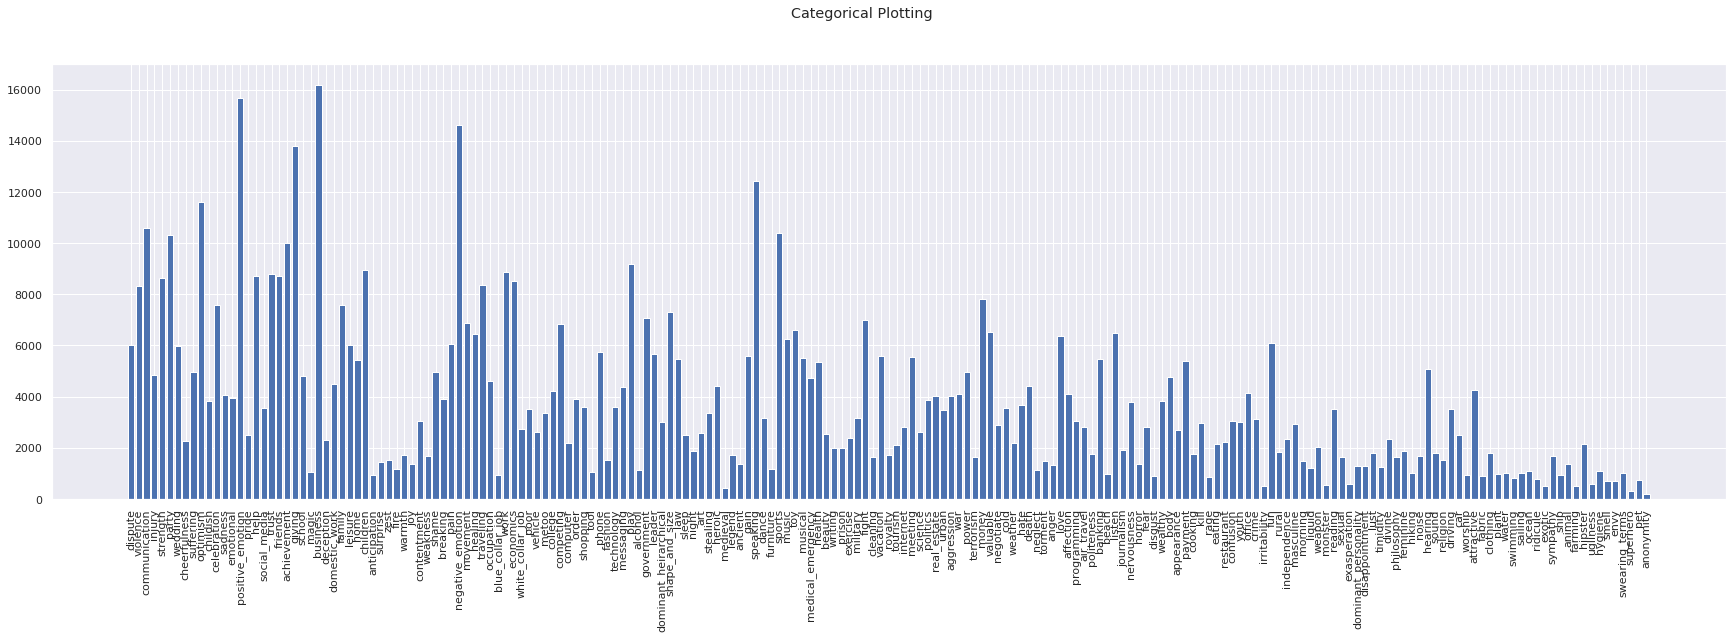

In [ ]:
import matplotlib.pyplot as plt

names = list(dict_topics_males.keys())
values = list(dict_topics_males.values())

fig, axs = plt.subplots(1, 1, figsize=(30, 8), sharey=True)
axs.bar(names, values)
plt.xticks(rotation=90)
fig.suptitle('Categorical Plotting')

Text(0.5, 0.98, 'Categorical Plotting')

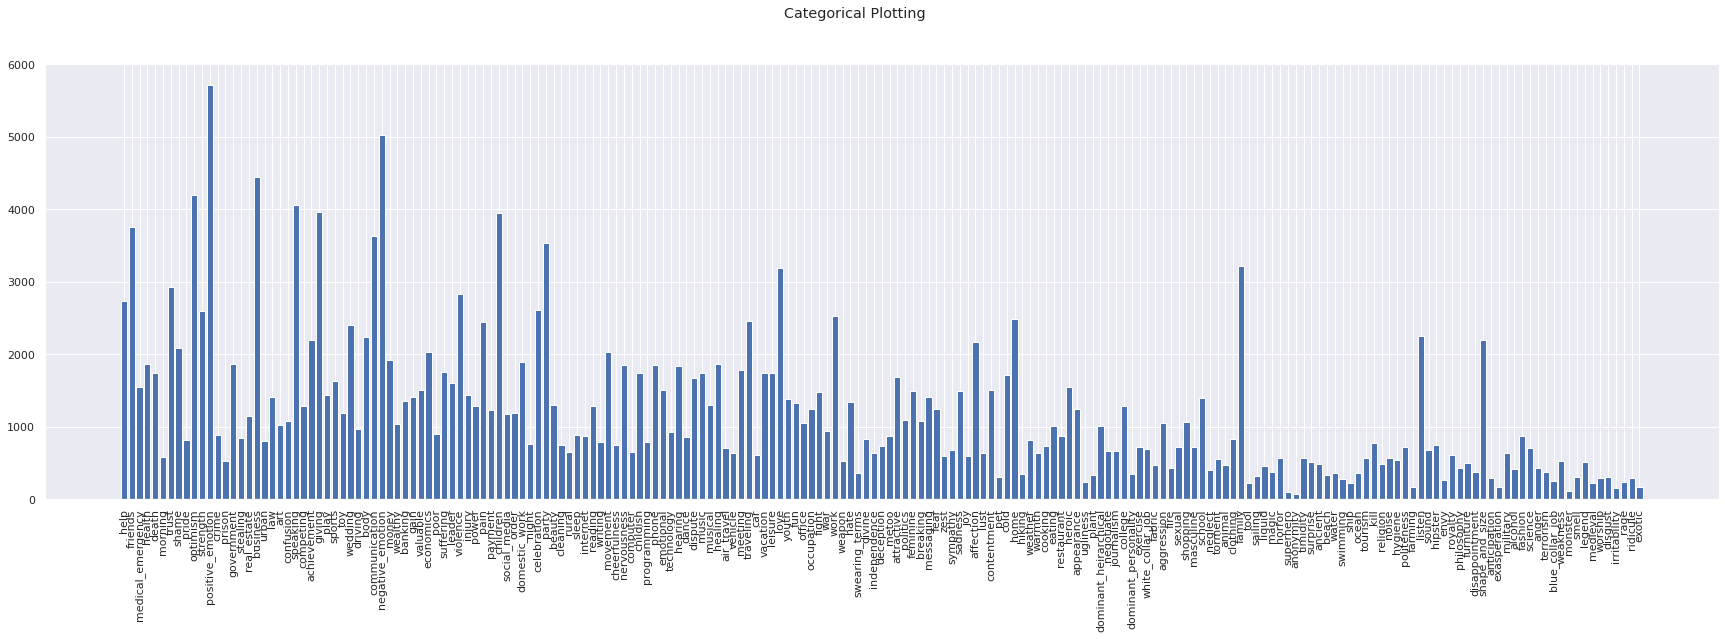

In [ ]:
import matplotlib.pyplot as plt

names = list(dict_topics_females.keys())
values = list(dict_topics_females.values())

fig, axs = plt.subplots(1, 1, figsize=(30, 8), sharey=True)
axs.bar(names, values)
plt.xticks(rotation=90)
fig.suptitle('Categorical Plotting')

In [ ]:
topics_counts_df = pd.DataFrame.from_dict(dict_topics,orient='index', columns=['count'])
topics_counts_df.head()

,count
dispute,6031
violence,8322
communication,10571
injury,4841
strength,8644


In [ ]:
topics_counts_df.shape

(195, 2)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", color_codes=True)


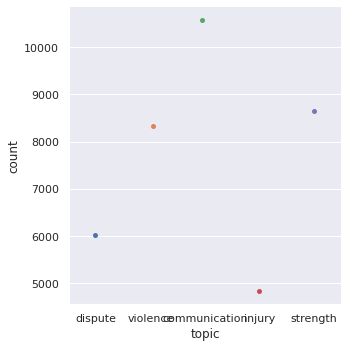

In [ ]:
from matplotlib import rcParams

topics_counts_df['topic'] = topics_counts_df.index
# figure size in inches
ax = sns.catplot(x='topic', y="count", data=topics_counts_df.head())